## Modelling and Training Notebook

### Imports

In [1]:
import pickle
import time
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import torch
import torch.nn.functional as F
from sklearn.metrics import mean_absolute_error, mean_squared_error

import config as cfg

In [2]:
def load_ds(ds_filename):
    with open(ds_filename, "rb") as f:
        return pickle.load(f)

Custom metrics function for MAPE and Theil-U

In [3]:
def mean_absolute_percentage_error(y_true, y_pred):
    
    return np.mean(np.abs((y_true - y_pred) / y_true) * 100)

def theil_u(y_true, y_pred):
    
    den = np.sqrt(np.mean(y_true**2)) + np.sqrt(np.mean(y_pred**2)) 
    
    return mean_squared_error(y_true, y_pred) / den

Transform pandas dataframe into dataloader for training

In [4]:
def df_to_dataloader(ds, targetcol_name="Target"):
    tmpdf_train = ds['train'].copy()
    tmpdf_val = ds['val'].copy()
    tmpdf_test = ds['test'].copy()
    target_train = tmpdf_train[targetcol_name]
    target_val = tmpdf_val[targetcol_name]
    target_test = tmpdf_test[targetcol_name]
    
    mu, sigma = tmpdf_train["Returns"].mean(), tmpdf_train["Returns"].std()
    
    tmpdf_train = tmpdf_train.drop(columns = ["Date", "Close", "Close i-1", "Returns", targetcol_name])
    tmpdf_val = tmpdf_val.drop(columns = ["Date", "Close", "Close i-1", "Returns", targetcol_name])
    tmpdf_test = tmpdf_test.drop(columns = ["Date", "Close", "Close i-1", "Returns", targetcol_name])
    """
    tmpdf_train = (tmpdf_train - mu)/sigma
    tmpdf_val = (tmpdf_val - mu)/sigma
    tmpdf_test = (tmpdf_test - mu)/sigma
    target_train = (target_train - mu)/sigma
    target_val = (target_val - mu)/sigma
    target_test = (target_test - mu)/sigma
    """
    trainds = torch.utils.data.TensorDataset(torch.Tensor(np.array(tmpdf_train)), torch.Tensor(np.array(target_train)))
    trainloader = torch.utils.data.DataLoader(trainds, batch_size=4, shuffle=False)
    valds = torch.utils.data.TensorDataset(torch.Tensor(np.array(tmpdf_val)), torch.Tensor(np.array(target_val)))
    valloader = torch.utils.data.DataLoader(valds, batch_size=2, shuffle=False)
    testds = torch.utils.data.TensorDataset(torch.Tensor(np.array(tmpdf_test)), torch.Tensor(np.array(target_test)))
    testloader = torch.utils.data.DataLoader(testds, batch_size=2, shuffle=False)
    return trainloader, valloader, testloader

In [5]:
SPY_ds = load_ds("data/SPY_ds.pkl")
DIA_ds = load_ds("data/DIA_ds.pkl")
QQQ_ds = load_ds("data/QQQ_ds.pkl")

In [6]:
trainloader_SPY_MLP, valloader_SPY_MLP, testloader_SPY_MLP = df_to_dataloader(SPY_ds["MLP"])

In [7]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.hidden = torch.nn.Linear(self.input_size, self.hidden_size)
        self.out = torch.nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, x):
        x = torch.sigmoid(self.hidden(x))
        x = self.out(x)
        
        return x

In [8]:
def init_normal(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.normal_(m.weight, mean=0, std=1)

SPY_MLP = MLP(cfg.train_parameters['SPY']['MLP']['input_size'],
              cfg.train_parameters['SPY']['MLP']['hidden_size'],
              cfg.train_parameters['SPY']['MLP']['output_size']
             )

SPY_MLP.apply(init_normal)

if cfg.train_parameters["SPY"]["MLP"]["optim"] == "SGD":
    SPY_MLP_optimizer = torch.optim.SGD(SPY_MLP.parameters(),
                                        lr = cfg.train_parameters["SPY"]["MLP"]["lr"],
                                        momentum = cfg.train_parameters["SPY"]["MLP"]["momentum"]
                                       )
else:
    SPY_MLP_optimizer = torch.optim.Adam(SPY_MLP.parameters(),
                                        lr = cfg.train_parameters["SPY"]["MLP"]["lr"],
                                        momentum = cfg.train_parameters["SPY"]["MLP"]["momentum"]
                                        )

loss_fn = torch.nn.MSELoss(reduction="mean")

In [9]:
train_losses, val_losses = [], []

start_time = time.time()
for epoch in range(cfg.train_parameters["SPY"]["MLP"]["epochs"]):
    SPY_MLP.train()
    
    train_loss, val_loss = [], []
    
    for features, target in trainloader_SPY_MLP:
        SPY_MLP_optimizer.zero_grad()
        
        outputs = SPY_MLP(features)
        loss = loss_fn(outputs, target.view(-1,1))
        loss.backward()
        SPY_MLP_optimizer.step()
        
        train_loss.append(loss.item())
    
    SPY_MLP.eval()
    with torch.no_grad():
        for features, target in valloader_SPY_MLP:
            outputs = SPY_MLP(features)
            loss = loss_fn(outputs, target.view(-1,1))
            
            val_loss.append(loss.item())
    
    train_losses.append(np.mean(train_loss))
    val_losses.append(np.mean(val_loss))
    
    if (epoch+1) % 1000 == 0 or epoch+1 == 1:
        print("[{}] Epoch {}/{} - Train Loss : {:.4f} / Val Loss : {:.4f}".format(time.strftime("%M:%S", time.gmtime(time.time()-start_time)),
                                                                                  epoch + 1,
                                                                                  cfg.train_parameters["SPY"]["MLP"]["epochs"],
                                                                                  np.mean(train_loss),
                                                                                  np.mean(val_loss)))

[00:00] Epoch 1/30000 - Train Loss : 0.0223 / Val Loss : 0.0011
[01:48] Epoch 1000/30000 - Train Loss : 0.0005 / Val Loss : 0.0002
[03:40] Epoch 2000/30000 - Train Loss : 0.0005 / Val Loss : 0.0002
[05:35] Epoch 3000/30000 - Train Loss : 0.0004 / Val Loss : 0.0002
[07:45] Epoch 4000/30000 - Train Loss : 0.0003 / Val Loss : 0.0001
[09:43] Epoch 5000/30000 - Train Loss : 0.0003 / Val Loss : 0.0001
[11:44] Epoch 6000/30000 - Train Loss : 0.0003 / Val Loss : 0.0001
[13:48] Epoch 7000/30000 - Train Loss : 0.0003 / Val Loss : 0.0001
[15:46] Epoch 8000/30000 - Train Loss : 0.0002 / Val Loss : 0.0001
[17:40] Epoch 9000/30000 - Train Loss : 0.0002 / Val Loss : 0.0001
[19:36] Epoch 10000/30000 - Train Loss : 0.0002 / Val Loss : 0.0001
[21:38] Epoch 11000/30000 - Train Loss : 0.0002 / Val Loss : 0.0001
[23:29] Epoch 12000/30000 - Train Loss : 0.0002 / Val Loss : 0.0001
[25:23] Epoch 13000/30000 - Train Loss : 0.0002 / Val Loss : 0.0001
[27:17] Epoch 14000/30000 - Train Loss : 0.0002 / Val Loss : 

KeyboardInterrupt: 

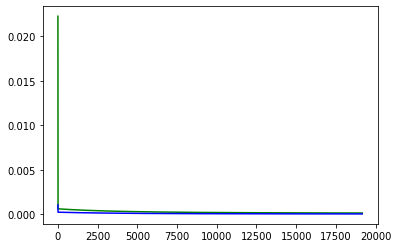

In [11]:
import matplotlib.pyplot as plt

plt.plot(train_losses, color="g")
plt.plot(val_losses, color="b");

In [12]:
train_preds, train_targets = [], []
val_preds, val_targets = [], []
test_preds, test_targets = [], []

SPY_MLP.eval()
with torch.no_grad():
    for features, target in trainloader_SPY_MLP:
        outputs = SPY_MLP(features)
        train_preds += outputs.numpy().T.tolist()[0]
        train_targets += target.numpy().tolist()
    for features, target in valloader_SPY_MLP:
        outputs = SPY_MLP(features)
        val_preds += outputs.numpy().T.tolist()[0]
        val_targets += target.numpy().tolist()
    for features, target in testloader_SPY_MLP:
        outputs = SPY_MLP(features)
        test_preds += outputs.numpy().T.tolist()[0]
        test_targets += target.numpy().tolist()

train_preds, train_targets = np.array(train_preds), np.array(train_targets)
val_preds, val_targets = np.array(val_preds), np.array(val_targets)
test_preds, test_targets = np.array(test_preds), np.array(test_targets)

In [13]:
print("Training Set")
print("RMSE : ", mean_squared_error(train_targets, train_preds))
print("MAE : ", mean_absolute_error(train_targets, train_preds))
print("MAPE : ", mean_absolute_percentage_error(train_targets, train_preds))
print("Theil-U :", theil_u(train_targets, train_preds))
print("")
print("Validation Set")
print("RMSE : ", mean_squared_error(val_targets, val_preds))
print("MAE : ", mean_absolute_error(val_targets, val_preds))
print("MAPE : ", mean_absolute_percentage_error(val_targets, val_preds))
print("Theil-U :", theil_u(val_targets, val_preds))
print("")
print("Test Set")
print("RMSE : ", mean_squared_error(test_targets, test_preds))
print("MAE : ", mean_absolute_error(test_targets, test_preds))
print("MAPE : ", mean_absolute_percentage_error(test_targets, test_preds))
print("Theil-U :", theil_u(test_targets, test_preds))

Training Set
RMSE :  0.00016302873931463283
MAE :  0.009161640314054949
MAPE :  inf
Theil-U : 0.009060463039327598

Validation Set
RMSE :  6.393952796569322e-05
MAE :  0.006188812029225999
MAPE :  inf
Theil-U : 0.005952004966826534

Test Set
RMSE :  6.964694243173553e-05
MAE :  0.006445284606193028
MAPE :  92.61326318508289
Theil-U : 0.0062237892097427435


/Users/Chayan/Dev/env/ML/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Chayan/Dev/env/ML/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


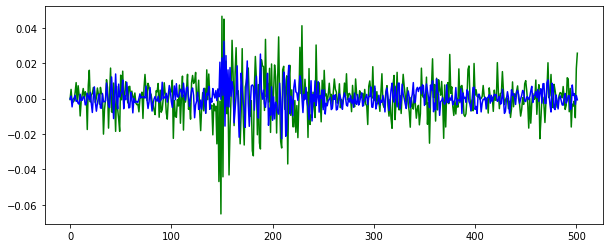

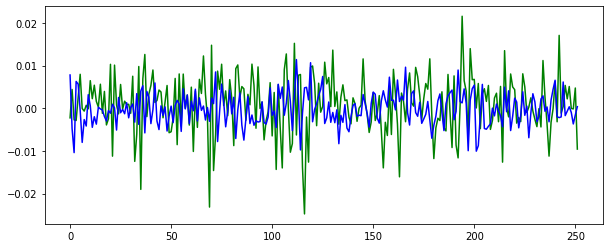

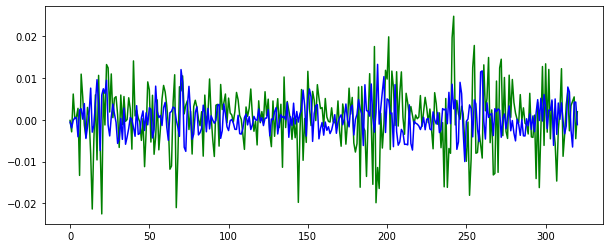

In [14]:
plt.figure(figsize=(10,4))
plt.plot(train_targets, color="g")
plt.plot(train_preds, color="b");
plt.figure(figsize=(10,4))
plt.plot(val_targets, color="g")
plt.plot(val_preds, color="b");
plt.figure(figsize=(10,4))
plt.plot(test_targets, color="g")
plt.plot(test_preds, color="b");